In [22]:
import cv2
import numpy as np
# from picamera2 import Picamera2
from matplotlib import pyplot as plt
import imageprocessor as calibration





In [23]:
# User Variables
gaussian_blur = 15
threshold_value = 15
dilation_value = 6
dilation_iterations = 2
dilation_kernel = np.ones((dilation_value, dilation_value), np.uint8)
contour_min_area = 1  # percent of frame area
contour_max_area = 80 # percent of frame area
targets_max = 4  # max targets returned
target_on_contour = True  # else use box size
target_return_box = False  # True = return (x, y, bx, by, bw, bh), else check target_return_size
target_return_size = False  # True = return (x, y, percent_frame_size), else just (x, y)
contour_draw = True
contour_line = 1  # border width
contour_point = 4  # centroid point radius
contour_pline = -1  # centroid point line width
contour_color = (0, 255, 255)  # BGR color
contour_box_draw = True
contour_box_line = 1  # border width
contour_box_point = 4  # centroid point radius
contour_box_pline = -1  # centroid point line width
contour_box_color = (0, 255, 0)  # BGR color
targets_draw = True
targets_point = 4  # centroid radius
targets_pline = -1  # border width
targets_color = (0, 0, 255)  # BGR color

Image dimensions: width=3280, height=2464, area=8081920


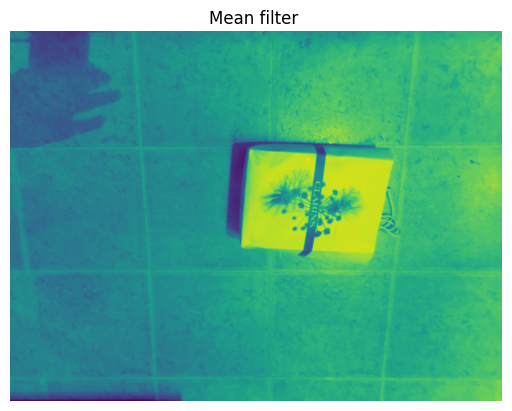

In [18]:
frame = cv2.imread('camera0.jpg')
frame = calibration.undistortRectify(frame)

    # Frame dimensions
height = frame.shape[0]
width = frame.shape[1]
area = width * height
print(f"Image dimensions: width={width}, height={height}, area={area}")

    # Grayscale
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Blur
blurred = cv2.GaussianBlur(gray, (gaussian_blur, gaussian_blur), 0)

plt.imshow(blurred)
plt.title('Mean filter ')
plt.axis('off')  # Turn off axis
plt.show()
imgrgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


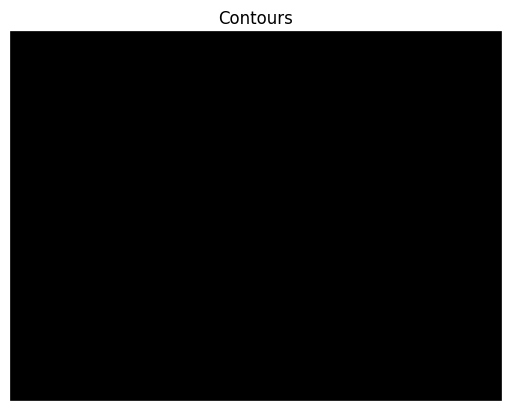

In [19]:
    # Threshold
_, thresh = cv2.threshold(blurred, threshold_value, 255, cv2.THRESH_BINARY)

    # Dilation
dilated = cv2.dilate(thresh, dilation_kernel, iterations=dilation_iterations)

    # Get contours
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 # Create a blank image to draw contours on
contour_img = np.zeros((height, width), dtype=np.uint8)

    # Draw the contours on the blank image
cv2.drawContours(contour_img, contours, -1, (255), 1)  # Drawing white contours with a thickness of 1

    # Display the contours image
plt.imshow(contour_img, cmap='gray')
plt.title('Contours')
plt.axis('off')  # Turn off axis
plt.show()
    

In [20]:
image_data = np.array(imgrgb)
flat_img = image_data.reshape(-1, 3)

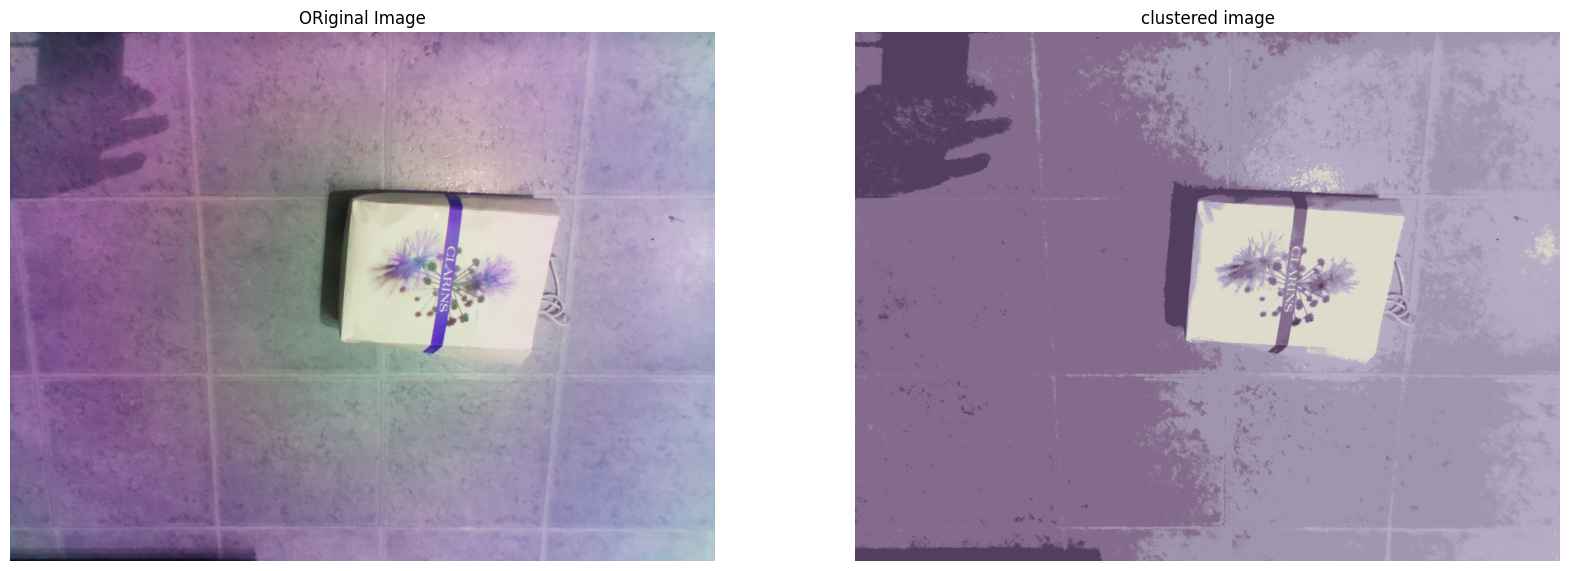

In [25]:
K = 5

flat_img = np.float32(flat_img)

# Perform K-means clustering
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# Set flags (Just to avoid line break in the code)
flags = cv2.KMEANS_RANDOM_CENTERS

ret, label, center = cv2.kmeans(flat_img,K,None,criteria,10,flags)

# Labels will contain the cluster assignments for each pixel
# Centers will contain the centroid values for each cluster


# convert it back to normal for display 

center = np.uint8(center)
res = center[label.flatten()]
res1 = res.reshape((frame.shape))




# mathlab plot 
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off') 
plt.title('ORiginal Image')
plt.subplot(1, 2, 2)
plt.imshow(res1)
plt.title('clustered image')
plt.axis('off') 
plt.show()

In [ ]:
# Filter and sort targets
    targets = []
    for c in contours:
        contour_area = cv2.contourArea(c)
        x, y, w, h = cv2.boundingRect(c)
        box_area = w * h

        if target_on_contour:
            p = 100 * contour_area / area
            if contour_min_area <= p <= contour_max_area:
                M = cv2.moments(c)
                if M['m00'] != 0:
                    cx = int(M['m10'] / M['m00'])
                    cy = int(M['m01'] / M['m00'])
                    targets.append((p, cx, cy, x, y, w, h, c))
        else:
            p = 100 * box_area / area
            if contour_min_area <= p <= contour_max_area:
                cx = x + w // 2
                cy = y + h // 2
                targets.append((p, cx, cy, x, y, w, h, c))

    targets.sort(reverse=True)
    targets = targets[:targets_max]

    # Draw contours and boxes on the frame
    if contour_draw:
        for size, cx, cy, x, y, w, h, c in targets:
            cv2.drawContours(frame, [c], 0, contour_color, contour_line)
            cv2.circle(frame, (cx, cy), contour_point, contour_color, contour_pline)

    if contour_box_draw:
        for size, cx, cy, x, y, w, h, c in targets:
            cv2.rectangle(frame, (x, y), (x + w, y + h), contour_box_color, contour_box_line)
            cv2.circle(frame, (x + w // 2, y + h // 2), contour_box_point, contour_box_color, contour_box_pline)

    if targets_draw:
        for size, cx, cy, x, y, w, h, c in targets:
            cv2.circle(frame, (cx, cy), targets_point, targets_color, targets_pline)

    # Return target coordinates
    if target_return_box:
        return [(cx, cy, x, y, w, h) for (size, cx, cy, x, y, w, h, c) in targets]
    elif target_return_size:
        return [(cx, cy, size) for (size, cx, cy, x, y, w, h, c) in targets]
    else:
        return [(cx, cy) for (size, cx, cy, x, y, w, h, c) in targets]



In [ ]:
# Function to add crosshairs to a frame
def add_crosshairs(frame, x, y, r=20, lc=(0, 0, 255), cc=(0, 0, 255), lw=1, cw=1):
    x, y, r = int(round(x)), int(round(y)), int(round(r))
    cv2.line(frame, (x, y - r * 2), (x, y + r * 2), lc, lw)
    cv2.line(frame, (x - r * 2, y), (x + r * 2, y), lc, lw)
    cv2.circle(frame, (x, y), r, cc, cw)

cap_right = Picamera2(1)
cap_right.start()

# Example usage
while True:
    frame = cap_right.capture_array()
    targets = process_frame(frame)
    for (cx, cy) in targets:
        add_crosshairs(frame, cx, cy)
    cv2.imshow('Processed Frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap_right.release()
cap_right.stop()
cv2.destroyAllWindows()